In [1]:
import torch
from omegaconf import DictConfig
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger, WandbLogger

import numpy as np
import os

from tsl import logger
from tsl.data import ImputationDataset, SpatioTemporalDataModule
from tsl.data.preprocessing import StandardScaler
from tsl.datasets import AirQuality, MetrLA, PemsBay
from tsl.engines import Imputer
from tsl.experiment import Experiment
from tsl.metrics import numpy as numpy_metrics
from tsl.metrics import torch as torch_metrics
from tsl.nn.models import (BiRNNImputerModel, GRINModel, RNNImputerModel,
                           SPINHierarchicalModel, SPINModel)
from tsl.ops.imputation import add_missing_values
from tsl.transforms import MaskInput
from tsl.utils.casting import torch_to_numpy

from omegaconf import OmegaConf

from my_datasets import AirQualitySmaller, AirQualityAuckland
from KITS import KITS
from KITS_filler import GCNCycVirtualFiller

import matplotlib.pyplot as plt

In [2]:
list(range(int(36/2), 36))

[18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35]

In [3]:
def get_model_class(model_str):
    if model_str == 'rnni':
        model = RNNImputerModel
    elif model_str == 'birnni':
        model = BiRNNImputerModel
    elif model_str == 'grin':
        model = GRINModel
    elif model_str == 'spin':
        model = SPINModel
    elif model_str == 'spin-h':
        model = SPINHierarchicalModel
    elif model_str == 'kits':
        model = KITS
    else:
        raise NotImplementedError(f'Model "{model_str}" not available.')
    return model


def get_dataset(dataset_name: str, p_fault=0., p_noise=0., masked_s=None):
    if dataset_name == 'air':
        return AirQuality(impute_nans=True, small=True, masked_sensors=masked_s)
    if dataset_name == 'air_smaller':
        return AirQualitySmaller('../../../AirData/AQI/Stations', impute_nans=True, masked_sensors=masked_s)
    if dataset_name == 'air_auckland':
        return AirQualityAuckland('../../../AirData/Niwa', t_range=['2022-04-01', '2022-12-01'], masked_sensors=masked_s, agg_func='mean')
    if dataset_name.endswith('_point'):
        p_fault, p_noise = 0., 0.25
        dataset_name = dataset_name[:-6]
    if dataset_name.endswith('_block'):
        p_fault, p_noise = 0.0015, 0.05
        dataset_name = dataset_name[:-6]
    if dataset_name == 'la':
        return add_missing_values(MetrLA(),
                                  p_fault=p_fault,
                                  p_noise=p_noise,
                                  min_seq=12,
                                  max_seq=12 * 4,
                                  seed=9101112)
    if dataset_name == 'bay':
        return add_missing_values(PemsBay(),
                                  p_fault=p_fault,
                                  p_noise=p_noise,
                                  min_seq=12,
                                  max_seq=12 * 4,
                                  seed=56789)
    raise ValueError(f"Dataset {dataset_name} not available in this setting.")

In [4]:
def load_model_and_infer(og_path: str):
    result = []
    for root, dirs, files in os.walk(og_path):
        for name in files:
            if 'ckpt' in name:
                result.append(os.path.join(root, name))
    
    assert len(result)
    checkpoint_path = result[0]
    
    # Load configuration
    cfg = OmegaConf.load(os.path.join(og_path, 'config.yaml'))
    
    # Load dataset
    dataset = get_dataset(cfg.dataset.name, masked_s=cfg.dataset.masked_sensors)
    covariates = {'u': dataset.datetime_encoded('day').values}

    if cfg.model.name == 'kits':
        adj = dataset.get_connectivity(**cfg.dataset.connectivity, layout='dense')
    else:
        adj = dataset.get_connectivity(**cfg.dataset.connectivity)
    
    torch_dataset = ImputationDataset(
        target=dataset.dataframe(),
        mask=dataset.training_mask,
        eval_mask=dataset.eval_mask,
        covariates=covariates,
        transform=MaskInput(),
        connectivity=adj,
        window=cfg.window,
        stride=cfg.stride
    )
    
    scalers = {'target': StandardScaler(axis=(0, 1))}

    dm = SpatioTemporalDataModule(
        dataset=torch_dataset,
        scalers=scalers,
        splitter=dataset.get_splitter(**cfg.dataset.splitting),
        batch_size=cfg.batch_size,
        workers=cfg.workers)
    
    dm.setup(stage='test')
    
    # Load model
    model_cls = get_model_class(cfg.model.name)
    
    if cfg.model.name == 'kits':
        model_kwargs = dict(adj=adj, d_in=dm.n_channels, n_nodes=dm.n_nodes, args=cfg.model)
    else:
        model_kwargs = dict(n_nodes=torch_dataset.n_nodes,
                            input_size=torch_dataset.n_channels,
                            exog_size=torch_dataset.input_map.u.shape[-1])
        
    model_cls.filter_model_args_(model_kwargs)
    model_kwargs.update(cfg.model.hparams)

    trainer = Trainer(
        max_epochs=cfg.epochs,
        accelerator='gpu' if torch.cuda.is_available() else 'cpu',
        devices=[0])
    
    if cfg.model.name == 'kits':
        imputer = GCNCycVirtualFiller.load_from_checkpoint(checkpoint_path, model_class=model_cls, model_kwargs=model_kwargs)
    else:
        imputer = Imputer.load_from_checkpoint(checkpoint_path, model_class=model_cls, model_kwargs=model_kwargs)

    imputer.eval()

    # trainer.test(imputer, datamodule=dm)
    
    # # Run inference
    # trainer = torch.utils.data.DataLoader(dm.test_dataloader(), batch_size=cfg.batch_size)
    output = trainer.predict(imputer, dataloaders=dm.test_dataloader())
    output = imputer.collate_prediction_outputs(output)
    output = torch_to_numpy(output)
    
    y_hat, y_true, mask = (output['y_hat'], output['y'],
                           output.get('eval_mask', None))
    # mask[:, :, 4, :] = True
    res = dict(test_mae=numpy_metrics.mae(y_hat, y_true, mask),
               test_mre=numpy_metrics.mre(y_hat, y_true, mask),
               test_mape=numpy_metrics.mape(y_hat, y_true, mask),
               test_rmse=numpy_metrics.rmse(y_hat, y_true, mask))
    
    return y_hat, y_true, mask, res, dm, dataset


In [5]:
# checkpoint_path = '../logs/grin/air_auckland/2025-02-14/19-54-32'  # Path to model checkpoint
# checkpoint_path = '../logs/kits/air_auckland/2025-02-19/09-48-59'
# checkpoint_path = '../logs/grin/air_smaller/2025-02-14/14-55-20'
# checkpoint_path = '../logs/kits/air_smaller/2025-02-19/09-54-29'
# checkpoint_path = '../logs/kits/air_smaller/2025-02-19/10-55-18'
# checkpoint_path = '../logs/grin/air_smaller/2025-02-19/10-58-42'
# checkpoint_path = '../logs/grin/air_auckland/2025-02-19/15-37-49'
# checkpoint_path = '../logs/kits/air_auckland/2025-02-19/15-37-26'
# checkpoint_path = '../logs/grin/air_auckland/2025-02-20/22-32-34'     # 12
# checkpoint_path = '../logs/kits/air_auckland/2025-02-20/22-33-02'     # 12
# checkpoint_path = '../logs/birnni/air_auckland/2025-02-22/12-11-55'   # 12

# checkpoint_path = '../logs/grin/air_smaller/2025-02-21/10-00-18'      # 24
# checkpoint_path = '../logs/kits/air_smaller/2025-02-21/10-00-58'      # 24

# checkpoint_path = '../logs/grin/air_smaller/2025-02-21/10-04-01'      # 12
# checkpoint_path = '../logs/kits/air_smaller/2025-02-21/10-03-48'      # 12
# checkpoint_path = '../logs/birnni/air_smaller/2025-02-22/21-38-26'    # 12

## FINAL AUCKLAND RES
# Henderson
checkpoint_path = '../logs/grin/air_auckland/2025-02-22/23-45-18'       # 24
# checkpoint_path = '../logs/kits/air_auckland/2025-02-22/23-42-45'     # 24
# checkpoint_path = '../logs/birnni/air_auckland/2025-02-22/22-59-41'

# Henderson month 6
checkpoint_path = '../logs/grin/air_auckland/2025-02-23/00-37-22'
# checkpoint_path = '../logs/kits/air_auckland/2025-02-23/00-31-41'
# checkpoint_path = '../logs/birnni/air_auckland/2025-02-23/00-32-09'

# Mt Albert month 6
# checkpoint_path = '../logs/grin/air_auckland/2025-02-23/17-15-22'
# checkpoint_path = '../logs/kits/air_auckland/2025-02-23/17-15-37'
# checkpoint_path = '../logs/birnni/air_auckland/2025-02-23/17-15-57'

# Beijing Dataset
checkpoint_path = '../logs/kits/air/2025-02-23/18-56-03'
checkpoint_path = '../logs/grin/air/2025-02-23/18-57-03'
checkpoint_path = '../logs/birnni/air/2025-02-23/18-57-33'

y_hat, y_true, mask, res, dm, dataset = load_model_and_infer(checkpoint_path)
res

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4]


Predicting DataLoader 0:   0%|          | 0/23 [00:00<?, ?it/s]

Arguments ['edge_index', 'edge_weight'] are filtered out. Only args ['mask', 'u', 'x'] are forwarded to the model (BiRNNImputerModel).


Predicting DataLoader 0: 100%|██████████| 23/23 [00:00<00:00, 46.91it/s]


{'test_mae': 44.228046,
 'test_mre': 0.6246319744468954,
 'test_mape': 1.7391434,
 'test_rmse': 67.80563}

In [6]:
paths = ['../logs/kits/air/2025-02-23/18-56-03'
,'../logs/grin/air/2025-02-23/18-57-03'
,'../logs/birnni/air/2025-02-23/18-57-33']

deets = []
for path in paths:
    res = load_model_and_infer(path)
    deets.append(res)
    print(res[3])

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4]


Predicting DataLoader 0: 100%|██████████| 23/23 [00:00<00:00, 25.47it/s]
{'test_mae': 36.26339, 'test_mre': 0.5121472189672357, 'test_mape': 0.74323046, 'test_rmse': 64.63453}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4]


Predicting DataLoader 0:   0%|          | 0/23 [00:00<?, ?it/s]

Only args ['mask', 'edge_index', 'edge_weight', 'x', 'u'] are forwarded to the model (GRINModel).


Predicting DataLoader 0: 100%|██████████| 23/23 [00:36<00:00,  0.64it/s]
{'test_mae': 27.823832, 'test_mre': 0.392955505258613, 'test_mape': 1.3796021, 'test_rmse': 40.258533}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4]


Predicting DataLoader 0:   0%|          | 0/23 [00:00<?, ?it/s]

Arguments ['edge_index', 'edge_weight'] are filtered out. Only args ['mask', 'u', 'x'] are forwarded to the model (BiRNNImputerModel).


Predicting DataLoader 0: 100%|██████████| 23/23 [00:00<00:00, 75.47it/s]
{'test_mae': 44.228046, 'test_mre': 0.6246319744468954, 'test_mape': 1.7391434, 'test_rmse': 67.80563}


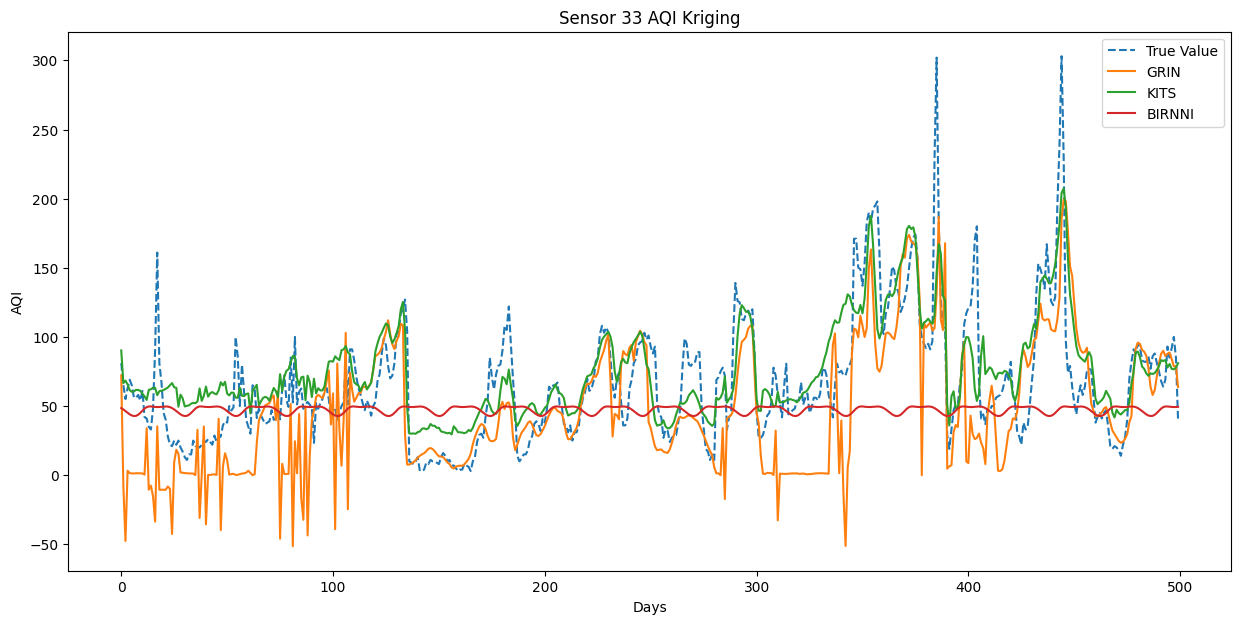

In [21]:
titles = ['GRIN', 'KITS', 'BIRNNI']
styles = ['-']
ranges = [0, 500]


plt.figure(figsize=(15,7))
plt.plot(deets[0][1][ranges[0]:ranges[1], 0, 33, :], '--', label='True Value')
for ind, deet in enumerate(deets):
    plt.plot(deet[0][ranges[0]:ranges[1], 0, 33, :], label=f'{titles[ind]}')
    # plt.plot(deet[1][ranges[0]:ranges[1], 0, 4, :], label=f'True Value')

plt.xlabel('Days')
plt.ylabel('AQI')
plt.legend()
plt.title('Sensor 33 AQI Kriging')
plt.show()

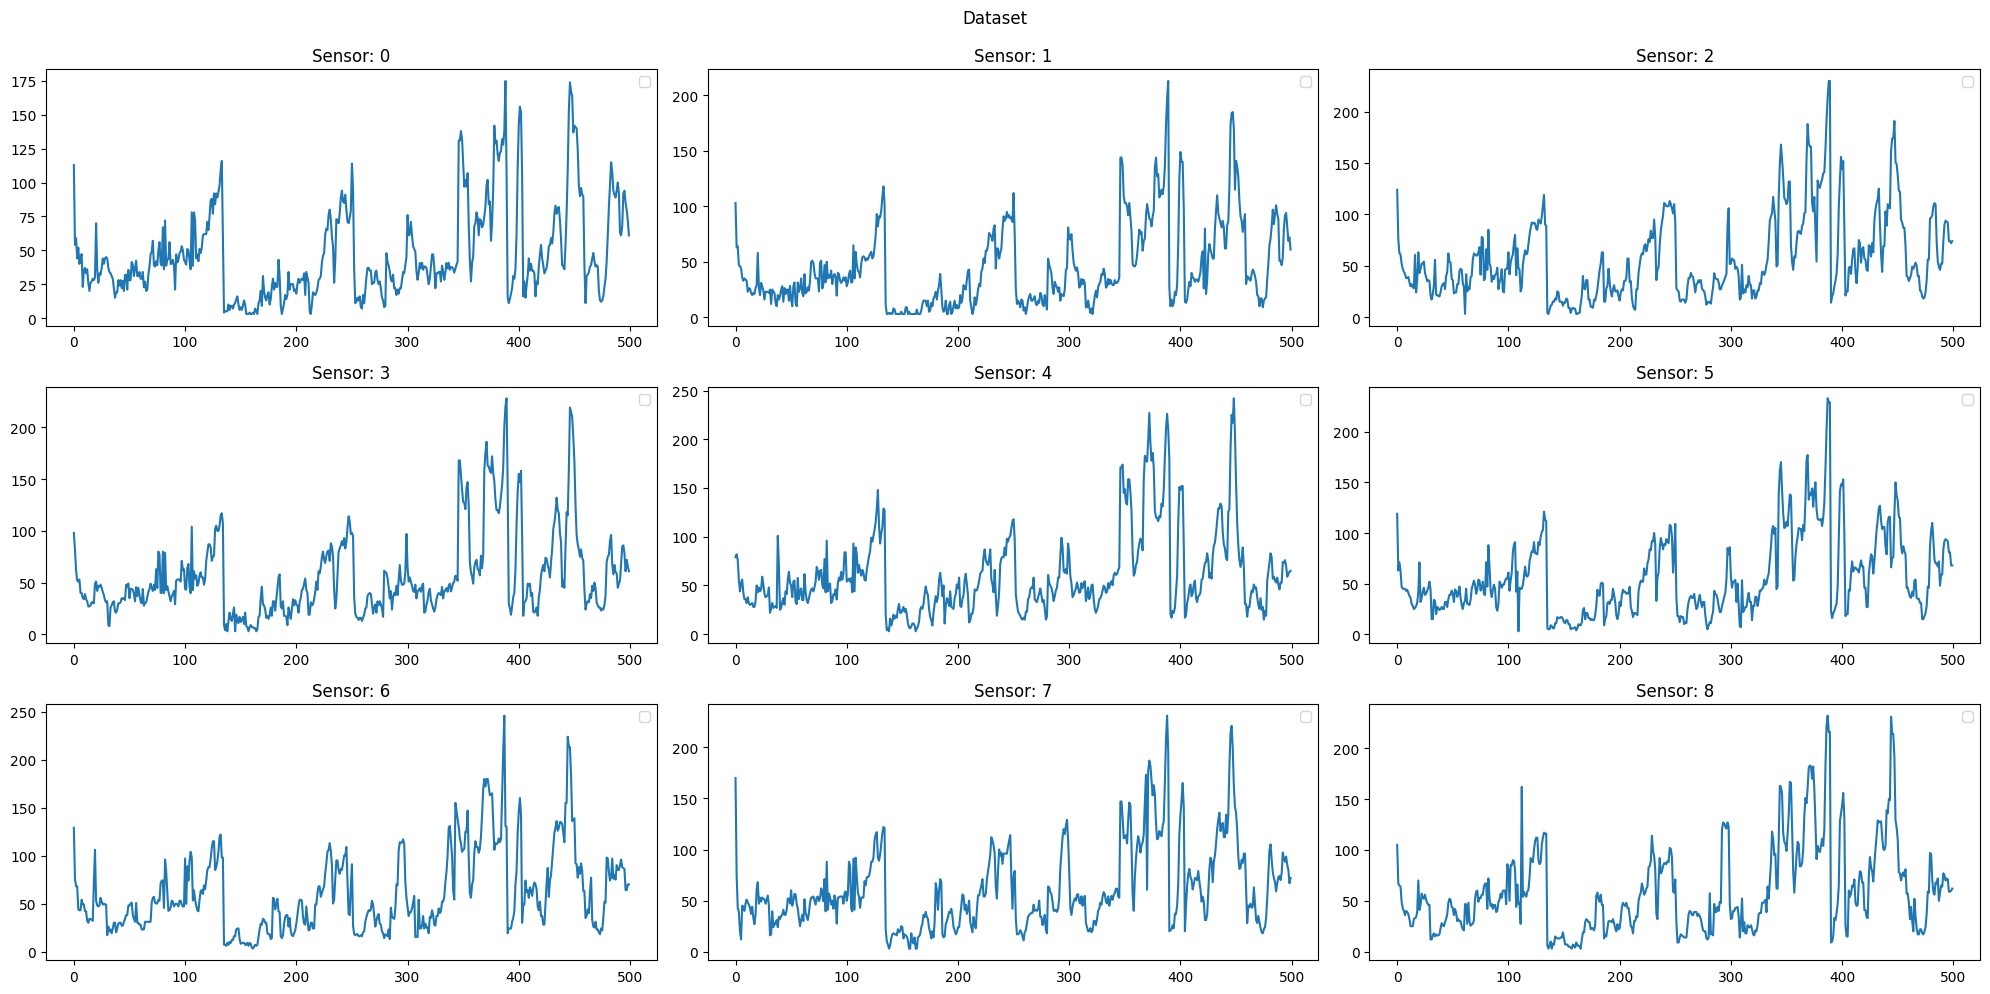

In [21]:
graph_hat = y_hat.reshape(y_hat.shape[0]*y_hat.shape[1], y_hat.shape[2], y_hat.shape[3])
graph_true = y_true.reshape(y_true.shape[0]*y_true.shape[1], y_true.shape[2], y_true.shape[3])

graph_hat = y_hat[:, 0, :, :]
graph_true = y_true[:, 0, :, :]

ranges = [0, 500]
indices = torch.where(torch.sum(dm.eval_mask, dim=0) > 0)[0]
sensors = ['Glen Eden','CBD','CBD','Browns Bay','Henderson','Mt. Albert']
indices = list(range(9))

if len(indices) == 1:
    plt.figure(figsize=(15,7))
    plt.plot(graph_hat[ranges[0]:ranges[1], indices[0], 0], color='g', label='Prediction')
    plt.plot(graph_true[ranges[0]:ranges[1], indices[0], 0], label='True Value')
    plt.title(f'GRU, Sensor: {sensors[indices[0]]}')
    plt.legend()
    plt.show()

else:
    fig, axs = plt.subplots(3, 3, figsize=(20,10))

    for i, ax in enumerate(axs.flatten()):
        # ax.plot(graph_hat[ranges[0]:ranges[1], indices[i], 0], color='g', label='Prediction')
        ax.plot(graph_true[ranges[0]:ranges[1], indices[i], 0])#, label='True Value')
        ax.set_title(f'Sensor: {indices[i]}')
        ax.legend()

    fig.suptitle('Dataset', y=.99)
    fig.tight_layout()
    plt.show()

In [ ]:
indices

[0, 1, 2, 3, 4, 5]

In [ ]:
m = np.mean(y_true, axis=1)

In [ ]:
m.shape

(1465, 6, 1)

In [ ]:
graph_true = y_true.reshape(y_true.shape[0]*y_true.shape[1], y_true.shape[2], y_true.shape[3])

In [ ]:
dm

SpatioTemporalDataModule(train_len=4082, val_len=216, test_len=1465, scalers=[target], batch_size=128)

In [ ]:
dm.torch_dataset.dataframe()

nodes,0,1,2,3,4,5
channels,0,0,0,0,0,0
datetime,,,,,,
2022-04-01 00:00:00+00:00,3.100000,2.673333,3.410000,7.001429,2.084038,26.935846
2022-04-01 01:00:00+00:00,3.182500,2.705000,3.127500,7.156667,1.952051,26.430929
2022-04-01 02:00:00+00:00,3.036667,2.400000,3.140000,5.253750,1.909407,26.247177
2022-04-01 03:00:00+00:00,3.560000,2.370000,3.030000,4.761667,2.000657,25.495037
2022-04-01 04:00:00+00:00,3.796667,2.780000,3.263333,4.273750,2.001064,22.854179
...,...,...,...,...,...,...
2022-11-30 19:00:00+00:00,4.507500,3.220572,6.007094,3.583112,4.593333,31.510000
2022-11-30 20:00:00+00:00,3.830000,3.538578,8.621893,4.527214,4.425000,31.017500


In [ ]:
np.array(dataset.df.iloc[2184:3671, 4])

array([3.8533332, 1.865    , 2.9666667, ..., 4.62     , 4.0575   ,
       1.6033334], dtype=float32)

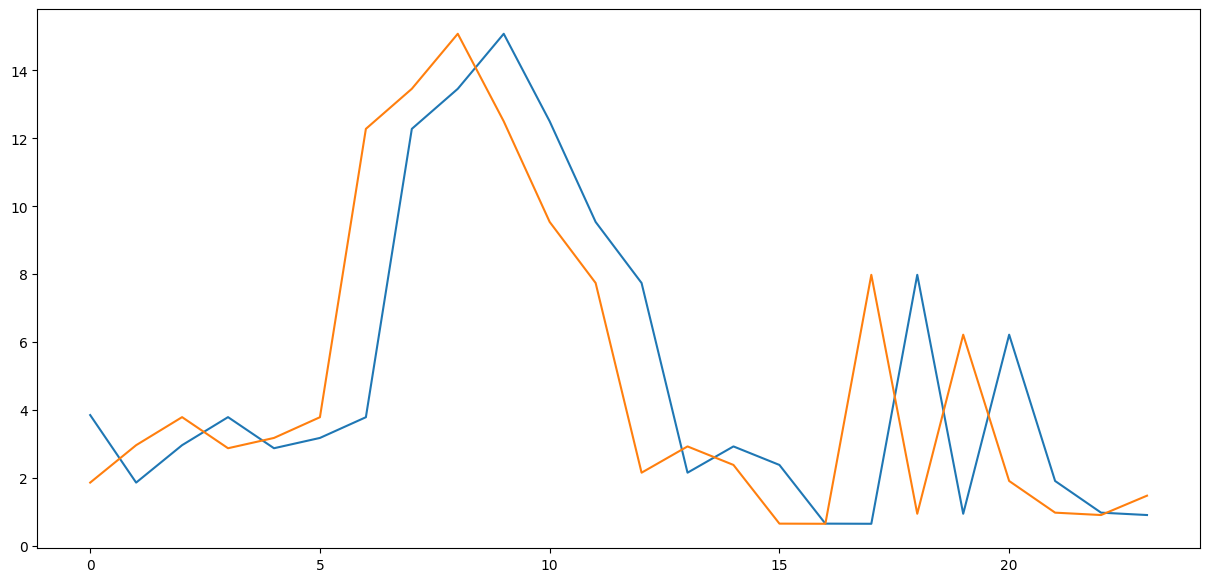

In [ ]:
plt.figure(figsize=(15, 7))
plt.plot(np.array(dm.torch_dataset.dataframe().iloc[2184:2184+24, 4]))
plt.plot(y_true[1, :, 4, :])
plt.show()

In [ ]:
y_hat.shape

(1465, 24, 6, 1)

In [ ]:
dm.torch_dataset

ImputationDataset(n_samples=5833, n_nodes=6, n_channels=1)

In [ ]:
dm.test_dataloader()

In [ ]:
dm.mask

tensor([[[1],
         [1],
         [1],
         [1],
         [0],
         [0]],

        [[1],
         [1],
         [1],
         [1],
         [0],
         [0]],

        [[1],
         [1],
         [1],
         [1],
         [0],
         [0]],

        ...,

        [[1],
         [0],
         [0],
         [0],
         [0],
         [1]],

        [[1],
         [0],
         [0],
         [0],
         [0],
         [1]],

        [[1],
         [0],
         [0],
         [0],
         [0],
         [1]]], dtype=torch.uint8)

In [ ]:
torch.where(torch.sum(dm.eval_mask, dim=0) > 0)

(tensor([4]), tensor([0]))

In [ ]:
torch.sum(dm.mask[:, 5, :])

tensor(4898)

In [ ]:
y_hat.shape

(1465, 24, 6, 1)